## Import Dependencies

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

#NLP Library
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# text preprocessing by Regular Expression
import re

# Model
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

## Read Dataset

In [2]:

train=pd.read_csv('train_tweets.csv')


In [3]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
print('Positive Tweet :',train[train['label']==0]['tweet'][0])
print('Negative Tweet :',train[train['label']==1]['tweet'][13])

Positive Tweet :  @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
Negative Tweet : @user #cnn calls #michigan middle school 'build the wall' chant '' #tcot  


## WordCloud Generation

### Positive Words

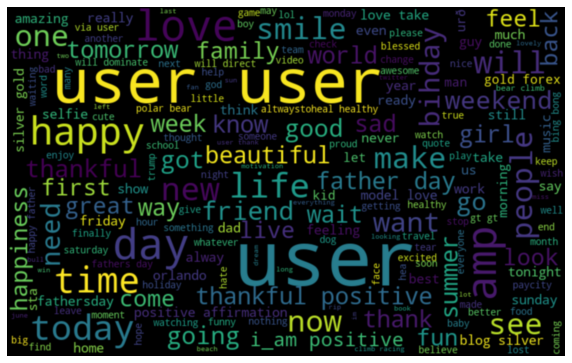

In [35]:
all_words = ' '.join([text for text in train[train['label']==0]['tweet']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bicubic')

plt.axis('off')
plt.show()

###  Negative Words

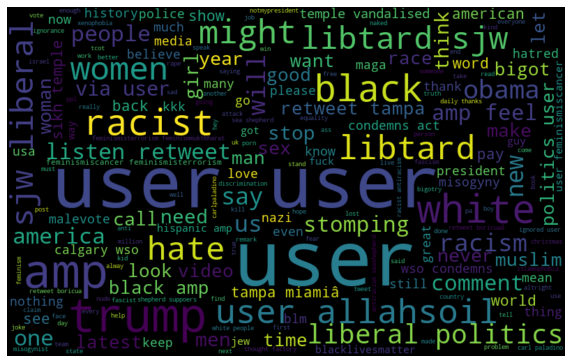

In [33]:
all_words = ' '.join([text for text in train[train['label']==1]['tweet']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [5]:
train.shape

(31962, 3)

## Imbalanced Dataset

In [6]:
train['label'].value_counts(normalize=True)

0    0.929854
1    0.070146
Name: label, dtype: float64

<AxesSubplot:xlabel='label', ylabel='count'>

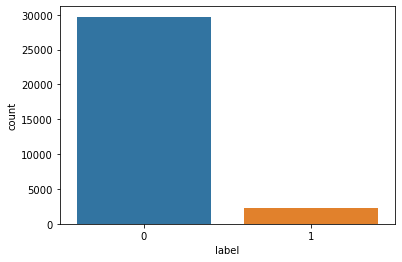

In [7]:
sns.countplot(train['label'])

We can see 90% of data belongs to 0 Class and less than 10% belongs to the 1 class. If we train our model with this data then our model will be highly bias. so we have to handle by using over sampling method

## Text Preprocessing

In [8]:
# convert tweets into original form ( remove punctuations eg. # and @)
# remove stopwords (eg. the,her,him)
lm=WordNetLemmatizer()
corpus=[]
for i in range(0,len(train)):
    review=re.sub('[^a-zA-Z]',' ',train['tweet'][i])
    review=review.lower()
    review=review.split()
    review=[lm.lemmatize(word) for word in review if word not in stopwords.words('english')]
    review=' '.join(review)
    corpus.append(review)
    

In [9]:
corpus

['user father dysfunctional selfish drag kid dysfunction run',
 'user user thanks lyft credit use cause offer wheelchair van pdx disapointed getthanked',
 'bihday majesty',
 'model love u take u time ur',
 'factsguide society motivation',
 'huge fan fare big talking leave chaos pay dispute get allshowandnogo',
 'user camping tomorrow user user user user user user user danny',
 'next school year year exam think school exam hate imagine actorslife revolutionschool girl',
 'love land allin cavs champion cleveland clevelandcavaliers',
 'user user welcome gr',
 'ireland consumer price index mom climbed previous may blog silver gold forex',
 'selfish orlando standwithorlando pulseshooting orlandoshooting biggerproblems selfish heabreaking value love',
 'get see daddy today day gettingfed',
 'user cnn call michigan middle school build wall chant tcot',
 'comment australia opkillingbay seashepherd helpcovedolphins thecove helpcovedolphins',
 'ouch junior angry got junior yugyoem omg',
 'thankf

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer 

In [11]:
# tweets covert into vectors by TF-IDF  
tfd=TfidfVectorizer(ngram_range=(1,3))
X_corpus=tfd.fit_transform(corpus)

In [12]:
#Oversampling for Imbalanced Data
from imblearn.over_sampling import RandomOverSampler
os=RandomOverSampler()
X,y=os.fit_sample(X_corpus,train['label'])

In [13]:
labels=pd.DataFrame(y,columns=['label'])

<AxesSubplot:xlabel='label', ylabel='count'>

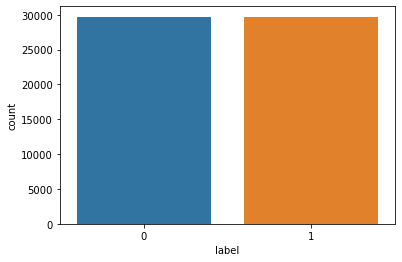

In [14]:
# we can see Balanced Data
sns.countplot(labels['label'])

In [15]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)


## Training Model

In [16]:
naive=MultinomialNB()
naive.fit(X_train,y_train)
y_pred=naive.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)
matrix=confusion_matrix(y_test,y_pred)
print('Accuracy :',accuracy)
print('Confusion Matrix :\n',matrix)


Accuracy : 0.9558378196500673
Confusion Matrix :
 [[5382  518]
 [   7 5981]]


## Hyperparameter Tuning by GridSearchCV

we have alpha parameter as a hyperparameter in Multinomial Naive Bayes which control model.

In [17]:
naive=MultinomialNB()
param_grid={ 'alpha':[0.01,0.05,0.1,0.5,1,5,10]}
grid=GridSearchCV(naive,param_grid=param_grid,cv=5,n_jobs=-1)

In [18]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]})

In [19]:
print(grid.best_params_)
print(grid.best_score_)

{'alpha': 0.01}
0.9823561914750101


## Training Final Model

In [20]:
# got 98% accuracy with parameter alpha=0.01
# train the Final model
naive=MultinomialNB(alpha=0.01)
naive.fit(X_train,y_train)
y_pred=naive.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)
matrix=confusion_matrix(y_test,y_pred)
report=classification_report(y_test,y_pred)
print('Accuracy :',accuracy)
print('------------------------------')
print('Confusion Matrix :\n',matrix)
print('------------------------------')
print('Classification Report :\n',report)

Accuracy : 0.9839333781965006
------------------------------
Confusion Matrix :
 [[5716  184]
 [   7 5981]]
------------------------------
Classification Report :
               precision    recall  f1-score   support

           0       1.00      0.97      0.98      5900
           1       0.97      1.00      0.98      5988

    accuracy                           0.98     11888
   macro avg       0.98      0.98      0.98     11888
weighted avg       0.98      0.98      0.98     11888



## Make Predictions

In [21]:
def prediction(tweet,trained_model,vector_model):
    review=re.sub('[^a-zA-Z]',' ',tweet)
    review=review.lower()
    review=review.split()
    review=[lm.lemmatize(word) for word in review if word not in stopwords.words('english')]
    review=' '.join(review)
    x=[review]
    test_review=tfd.transform(x)
    pred=naive.predict(test_review)[0]
    if pred==0:
        return 'Given Tweet has Positive Sentiment'
    else:
        return 'Given Tweet has Negative Sentiment'
    
    return pred

    
    

In [22]:
prediction('you are beautiful',naive,tfd)


'Given Tweet has Positive Sentiment'

## Get top 20 features for Positive and Negative

In [23]:
features=tfd.get_feature_names()

### Most Negative

In [40]:

sorted(zip(naive.coef_[0],features))[:20]

[(-16.233734528701895, 'aa'),
 (-16.233734528701895, 'aa recovery'),
 (-16.233734528701895, 'aa recovery sobriety'),
 (-16.233734528701895, 'aa suppoers'),
 (-16.233734528701895, 'aa suppoers dumpsterfire'),
 (-16.233734528701895, 'aaa'),
 (-16.233734528701895, 'aaa exam'),
 (-16.233734528701895, 'aaa exam college'),
 (-16.233734528701895, 'aaa studio'),
 (-16.233734528701895, 'aaa today'),
 (-16.233734528701895, 'aaa today last'),
 (-16.233734528701895, 'aaaaa'),
 (-16.233734528701895, 'aaaaa yes'),
 (-16.233734528701895, 'aaaaa yes yes'),
 (-16.233734528701895, 'aaaaaand'),
 (-16.233734528701895, 'aaaaaand come'),
 (-16.233734528701895, 'aaaaaand come take'),
 (-16.233734528701895, 'aaaaah'),
 (-16.233734528701895, 'aaaaah want'),
 (-16.233734528701895, 'aaaaah want know')]

### Most positive

In [41]:
sorted(zip(naive.coef_[0],features),reverse=True)[:20]

[(-4.733655700356475, 'user'),
 (-5.582476165130165, 'user user'),
 (-5.7205174316604035, 'libtard'),
 (-6.006771717852276, 'amp'),
 (-6.064999062911517, 'trump'),
 (-6.288997780550426, 'user user user'),
 (-6.2905092470556925, 'black'),
 (-6.290834030632732, 'white'),
 (-6.3283971500661975, 'liberal'),
 (-6.330283943772264, 'politics'),
 (-6.415273723380923, 'sjw'),
 (-6.424305201665131, 'sjw liberal politics'),
 (-6.424305201665131, 'sjw liberal'),
 (-6.424305201665131, 'might libtard libtard'),
 (-6.424305201665131, 'might libtard'),
 (-6.424305201665131, 'libtard sjw liberal'),
 (-6.424305201665131, 'libtard sjw'),
 (-6.424305201665131, 'libtard libtard sjw'),
 (-6.424305201665131, 'libtard libtard'),
 (-6.424305201665131, 'liberal politics')]